## Load dataset

In [2]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

## Import libraries

In [30]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from umap import UMAP
from scipy.stats import norm
import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from IPython.display import Image

optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

## Load train dataframe

In [2]:
data_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
train = pd.DataFrame(data_train)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Load test dataframe

In [3]:
data_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
test = pd.DataFrame(data_test)
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (1460, 81)
test shape: (1459, 80)


## Analyze target distribution

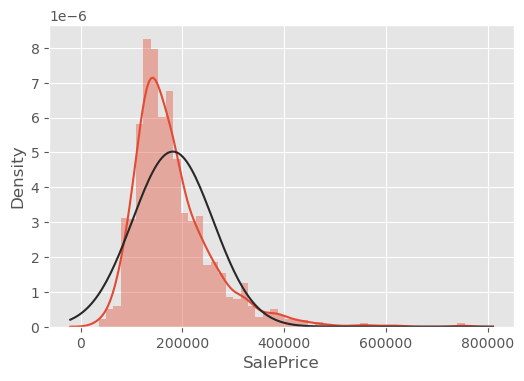

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.distplot(train.SalePrice, kde = True, hist=True, fit = norm)


### Logarithm the target to normalize it

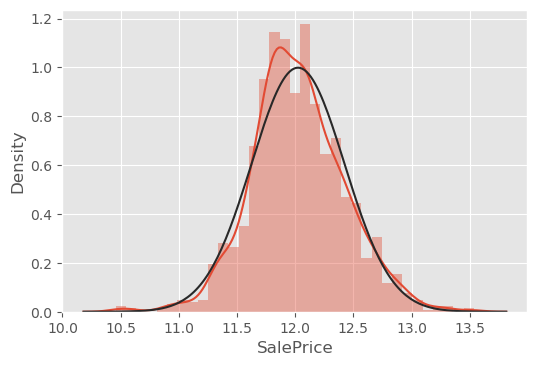

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.distplot(np.log(train.SalePrice), kde = True, hist=True, fit = norm);

## Analyze features

### Remove useless features

In [4]:
train.drop(['Id'],axis =1,inplace=True)
test.drop(['Id'],axis =1,inplace=True)

### Split numeric and string features

In [5]:
num_train = train.select_dtypes(exclude=[object])
num_test = test.select_dtypes(exclude=[object])
str_train = train.select_dtypes(include=[object])
str_test = test.select_dtypes(include=[object])

### Add derived features

In [6]:
# Add ages
num_train['HouseAge'] = 2021 - num_train.YearBuilt
num_train['RemodAge'] = 2021 - num_train.YearRemodAdd
num_train['SoldAge'] = 2021 - num_train.YrSold
num_test['HouseAge'] = 2021 - num_test.YearBuilt
num_test['RemodAge'] = 2021 - num_test.YearRemodAdd
num_test['SoldAge'] = 2021 - num_test.YrSold
# Add sum of all areas
num_train['HouseSum'] = num_train[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                           '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']].sum(axis=1)
num_test['HouseSum'] = num_test[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                           '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']].sum(axis=1)

<ipython-input-6-cd73e604c0c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_train['HouseAge'] = 2021 - num_train.YearBuilt
<ipython-input-6-cd73e604c0c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_train['RemodAge'] = 2021 - num_train.YearRemodAdd
<ipython-input-6-cd73e604c0c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

### Fill missed values

In [7]:
def fillna(df):
    for i in df.columns:
        if df[i].dtype == 'O': df[i] = df[i].fillna('missed')
        else: df[i] = df[i].fillna(0)
    return df

In [8]:
num_train = fillna(num_train)
num_test = fillna(num_test)

<ipython-input-7-c9ecdffc7e7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: df[i] = df[i].fillna(0)


## Pretrain to fill missed target values

In [9]:
x_pre, y_pre = num_train.drop('SalePrice', axis=1).to_numpy(), num_train['SalePrice'].to_numpy()
y_pre = np.log(y_pre)
x_test_pre = num_test.to_numpy()

In [10]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')
pre = xgboost.fit(x_pre,y_pre)
print('R2',r2_score(y_pre,xgboost.predict(x_pre)))

R2 0.9714318268298316


In [11]:
num_test['SalePrice'] = np.exp(xgboost.predict(x_test_pre))

<ipython-input-11-e00b535bc29f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_test['SalePrice'] = np.exp(xgboost.predict(x_test_pre))


## Clasterize number features

### Split full dataframe to numeric and string

In [12]:
train = pd.concat([num_train, str_train], axis=1, sort=True).reset_index(drop=True)
test = pd.concat([num_test, str_test], axis=1, sort=True).reset_index(drop=True)
full = pd.concat([train, test], sort=True).reset_index(drop=True)

In [13]:
str = full.select_dtypes(include=[object])
num = full.select_dtypes(exclude=[object])
# Fill none number elements
num = fillna(num)

<ipython-input-7-c9ecdffc7e7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: df[i] = df[i].fillna(0)


### Use embedding models

In [14]:
# Set 3 dimensions to get on the output
pca = PCA(n_components=3) 
tsne = TSNE(n_components=3, perplexity=50)
umap = UMAP(n_components=3, n_neighbors=5)
# Normilize
X = StandardScaler().fit_transform(num.drop('SalePrice', axis=1))
# Train
X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_umap = umap.fit_transform(X)

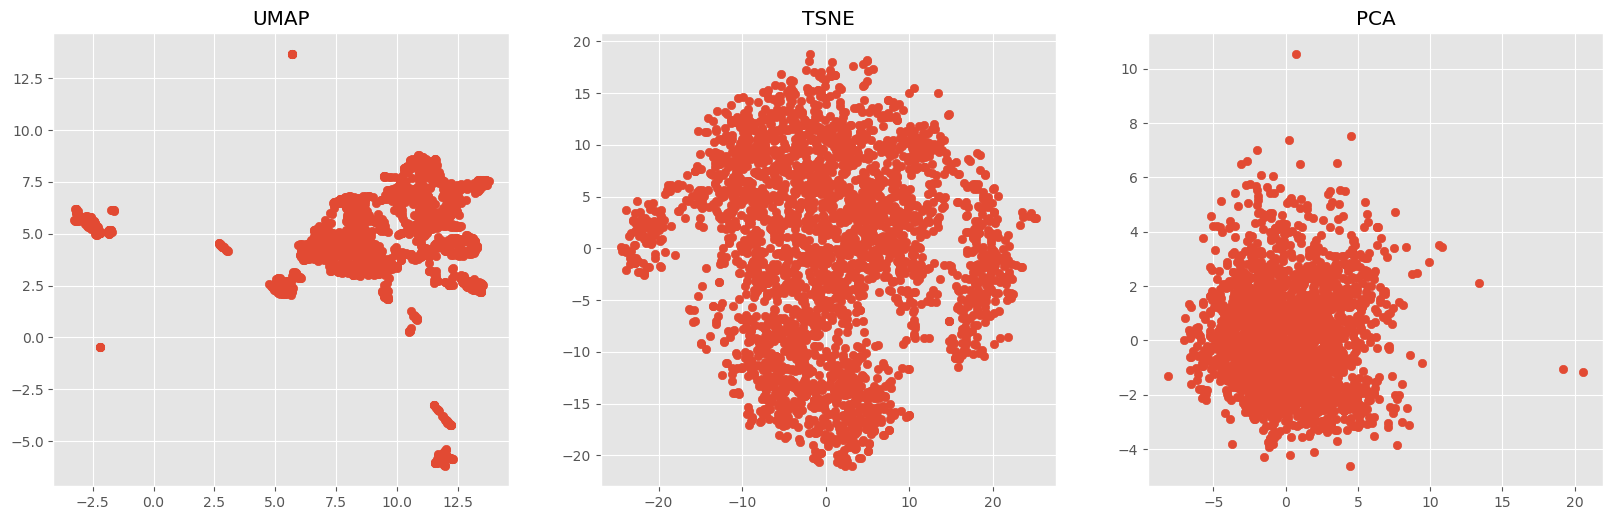

In [16]:
# Draw
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.scatter(X_umap[:, 0], X_umap[:, 1])
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1])
ax3.scatter(X_pca[:, 0], X_pca[:, 1])
ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

### Get clusters

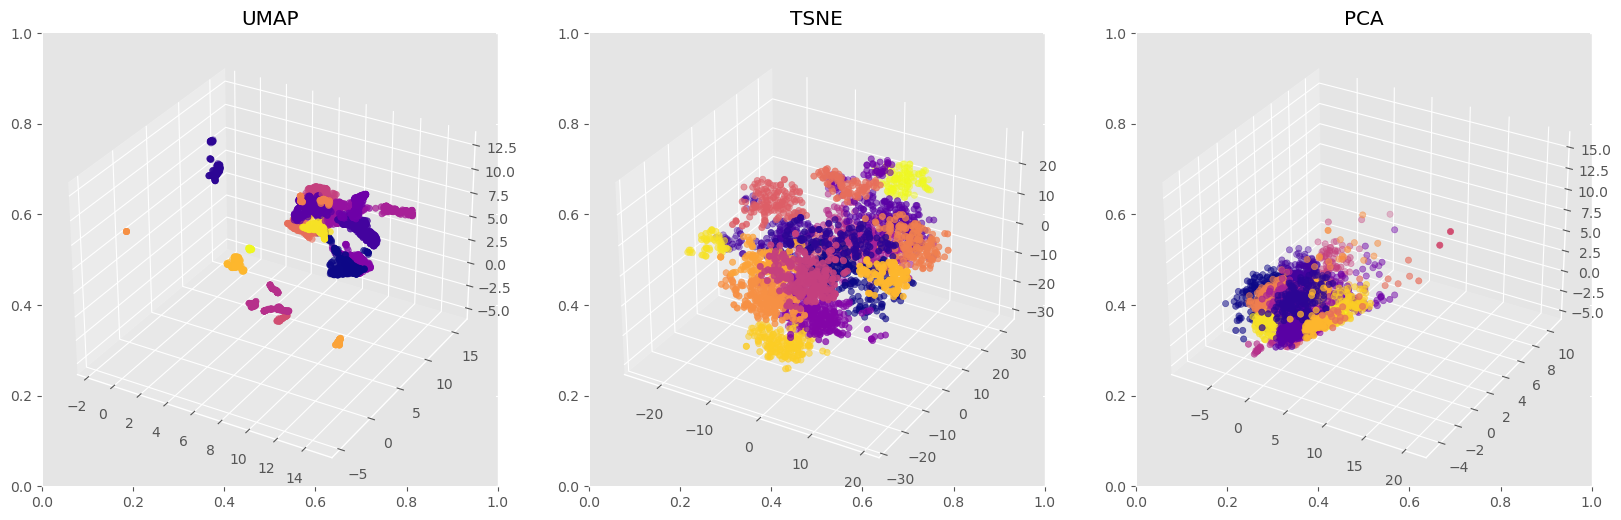

In [15]:
ag = AgglomerativeClustering(20)
ag_umap = ag.fit_predict(X_umap)
ag_tsne = ag.fit_predict(X_tsne)
ag_pca = ag.fit_predict(X_pca)
# Draw
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
ax1.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c = ag_umap, cmap='plasma')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c = ag_tsne, cmap='plasma')
ax3.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = ag_pca, cmap='plasma')
ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

### Add new (cluster) feature to numeric dataframe

In [16]:
num['Cluster'] = ag_pca
num = pd.concat([num, pd.get_dummies(num['Cluster'], prefix=('Cluster'))], axis=1)
num.drop('Cluster', axis=1, inplace=True)

<ipython-input-16-f1df246a6b46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['Cluster'] = ag_pca


## Analyze house quality features

In [17]:
# Move quality features from string to numeric features
qual_words = ['Qual', 'Class','QC']
qual_features = [i for i in str.columns if any(x in i for x in qual_words)]
str.drop(qual_features, axis = 1, inplace=True)
num = num.join(full[qual_features])
# Turn string values to numeric
num.replace(['Ex','Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1], inplace=True)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Label encoding on full dataframe

In [18]:
full = pd.concat([str, num], axis=1, sort=True).reset_index(drop=True)
# OneHotEncoding
for i in full.columns:
    if full[i].dtype == 'O' and i != 'SalePrice':
        full = pd.concat([full, pd.get_dummies(full[i], prefix=(i+'M'))], axis=1)
        full.drop(i, axis=1, inplace=True)
# Fill none values
full = fillna(full)


## Prepare data to train

### Split to train and test dataframes

In [19]:
train, test = full.loc[:1459], full.loc[1460:].drop(['SalePrice'], axis=1)

### Normilize data

In [20]:
X, Y = train[test.columns.to_list()].to_numpy(), train['SalePrice'].to_numpy()
Y = np.log(Y)
X_test = test.to_numpy()
Y_test = full.loc[1460:]['SalePrice'].to_numpy()

## Fit models

### Get best params from Optuna

In [45]:
# Set param's range
lr_from = 0.001
lr_to = 0.1
fr_from = 0.1
fr_to = 1
dec_from = 1
dec_to = 10

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    learning_rate = trial.suggest_float('learning_rate', lr_from, lr_to, log=True)
    bagging_fraction = trial.suggest_float('bagging_fraction', fr_from, fr_to, log=True)
    feature_fraction = trial.suggest_float('feature_fraction', fr_from, fr_to, log=True)
    num_leaves = trial.suggest_int('num_leaves', dec_from, dec_to, log=True)
    bagging_freq = trial.suggest_int('bagging_freq', dec_from, dec_to, log=True)
    bagging_seed = trial.suggest_int('bagging_seed', dec_from, dec_to, log=True)
    feature_fraction_seed = trial.suggest_int('feature_fraction_seed', dec_from, dec_to, log=True)
    # Models
    regr_obj = LGBMRegressor(objective='regression',num_leaves=num_leaves, learning_rate=learning_rate, 
                         n_estimators=5000,max_bin=200, bagging_fraction=bagging_fraction,
                         bagging_freq=bagging_freq, bagging_seed=bagging_seed,feature_fraction=feature_fraction,
                         feature_fraction_seed=feature_fraction_seed, verbose=-1)
    # Fit    
    regr_obj_data = regr_obj.fit(X,Y)
    pred = regr_obj_data.predict(X_test)
    error = r2_score(Y_test, pred)
    return error

# 3. Create a study object and optimize the objective function.
optune = optuna.create_study(direction='minimize')
optune.optimize(objective, n_trials=500, show_progress_bar=True)
optune.best_params

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.13074333858528117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13074333858528117
[LightGBM] [Warning] bagging_fraction is set=0.511099018798267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.511099018798267


100%|██████████| 1/1 [00:21<00:00, 21.03s/it]


{'learning_rate': 0.0920849773910443,
 'bagging_fraction': 0.511099018798267,
 'feature_fraction': 0.13074333858528117,
 'num_leaves': 6,
 'bagging_freq': 7,
 'bagging_seed': 1,
 'feature_fraction_seed': 5}

### RandomForestRegressor

R2 0.9839233526325311


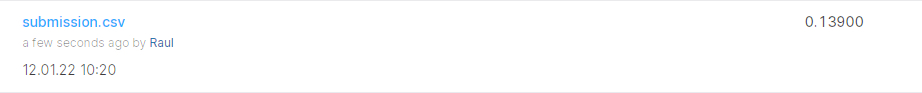

In [21]:
RF = RandomForestRegressor()
params = {'n_estimators': [100,200,1000,2000,5000],
          'max_depth': [3,10,11,12],
          'min_samples_split':[3,4,5]}
RF_GS = GridSearchCV(RF,
                  param_grid=params, 
                  cv=10, # number of folds
                  refit=True, # Set best params
                  n_jobs=4,
                  verbose=5)
RF.fit(X,Y)
print('R2',r2_score(Y,RF.predict(X)))
RF_result = np.exp(RF.predict(X_test))
Image("static/RF.jpg")

### XGBRegressor

R2 0.9791017982513777


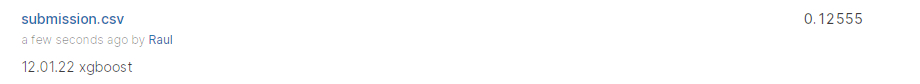

In [22]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')
xgboost.fit(X,Y)
print('R2',r2_score(Y,xgboost.predict(X)))
xgboost_result = np.exp(xgboost.predict(X_test))
Image("static/xgboost.jpg")

### LGBMRegressor

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
R2 0.9606489715592005


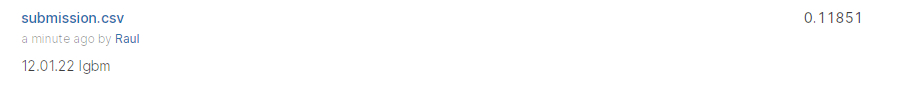

In [23]:
lgbm = LGBMRegressor(objective='regression',num_leaves=4, learning_rate=0.01, 
                         n_estimators=5000,max_bin=200, bagging_fraction=0.75,
                         bagging_freq=5, bagging_seed=7,feature_fraction=0.2,
                         feature_fraction_seed=7, verbose=-1)
lgbm.fit(X,Y)
print('R2',r2_score(Y,lgbm.predict(X)))
lgbm_result = np.exp(lgbm.predict(X_test))
Image("static/lgbm.jpg")

### CatBoostRegressor

R2 0.9842769413269818


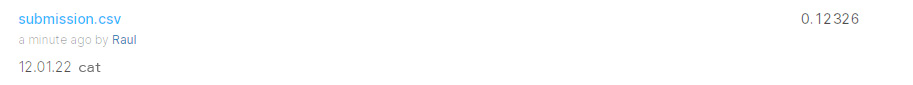

In [24]:
cat = CatBoostRegressor(iterations = 10000, learning_rate = .08, eval_metric = 'RMSE',
                        random_seed = 42, logging_level=  'Silent', loss_function = 'RMSE',
                        od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20,
                        l2_leaf_reg = 100, depth = 3, rsm = .6,
                        random_strength = 2, bagging_temperature = 10)
cat.fit(X,Y)
print('R2',r2_score(Y,cat.predict(X)))
cat_result = np.exp(cat.predict(X_test))
Image("static/cat.jpg")

## Upload best result to Kaggle

In [27]:
# Save to the file
to_save = pd.DataFrame(gbr_result.tolist(), columns=['SalePrice'], index=range(1461, 2920)).rename_axis('Id')
to_save.to_csv('submission.csv')
# Send to kaggle
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "13.01.22 gbr"


100%|██████████████████████████████████████| 33.6k/33.6k [00:02<00:00, 16.6kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

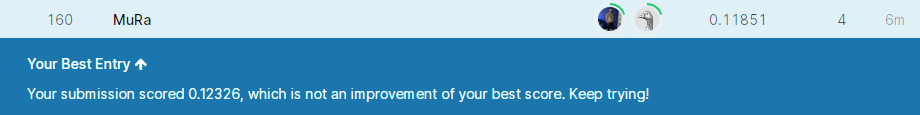

In [184]:
Image("static/leaderboard.jpg")

In [189]:
# def blend_models_predict(X):
#     return ((0.6 * lgbm.predict(X)) + \
#             (0.2 * xgboost.predict(X)) + \
#             (0.2 * cat.predict(X)))

# pred = blend_models_predict(X)

# print('R2',r2_score(Y,pred))

R2 0.9722416639380307
